In [13]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Read the csv file
df = pd.read_csv('.csv files/nepse_EBL.csv')
print(df.head()) #7 columns, including the Date. 

  Symbol       Date    Open   Close  Volume    High     Low
0    EBL  2/28/2013  1591.0  1599.0    2037  1599.0  1580.0
1    EBL   3/3/2013  1599.0  1590.0    6263  1600.0  1580.0
2    EBL   3/4/2013  1590.0  1591.0    7242  1605.0  1590.0
3    EBL   3/5/2013  1591.0  1590.0    2952  1601.0  1560.0
4    EBL   3/6/2013  1590.0  1600.0    4885  1609.0  1571.0


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

2265   2023-02-02
2266   2023-02-05
2267   2023-02-06
2268   2023-02-07
2269   2023-02-08
2270   2023-02-09
2271   2023-02-12
2272   2023-02-14
2273   2023-02-15
2274   2023-02-16
2275   2023-02-20
2276   2023-02-22
2277   2023-02-23
2278   2023-02-26
2279   2023-02-27
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[2:5]


In [5]:
#Date and change columns are not used in training. 
print(cols) #['Open', 'Close', 'Volume']

['Open', 'Close', 'Volume']


In [6]:
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)

<Axes: >

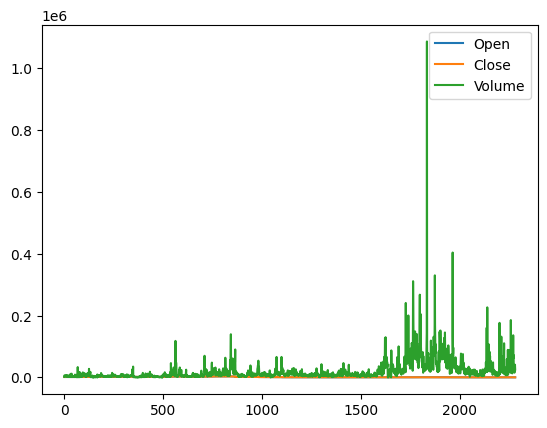

In [8]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [9]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [10]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 3. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [11]:
# Split data using an 80:20 split
final_dataset = df_for_training.values
train_data = final_dataset[0:203, :]
valid_data = final_dataset[203:, :]

In [14]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

In [15]:
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

In [16]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train

array([[0.33942029, 0.34173913, 0.33913043, ..., 0.32753623, 0.32898551,
        0.32608696],
       [0.34173913, 0.33913043, 0.33942029, ..., 0.32898551, 0.32608696,
        0.32753623],
       [0.33913043, 0.33942029, 0.33913043, ..., 0.32608696, 0.32753623,
        0.32637681],
       ...,
       [0.30405797, 0.30289855, 0.29855072, ..., 0.5173913 , 0.51362319,
        0.52028986],
       [0.30289855, 0.29855072, 0.29536232, ..., 0.51362319, 0.52028986,
        0.52231884],
       [0.29855072, 0.29536232, 0.30144928, ..., 0.52028986, 0.52231884,
        0.53188406]])

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(143, 60, 1)

In [18]:
# Create lstm neural network
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [20]:
# Train the model
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
history=lstm_model.fit(x_train, y_train,epochs=100, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/100
2/2 [==============================] - 13s 3s/step - loss: 0.0511 - val_loss: 0.0276
Epoch 2/100
2/2 [==============================] - 0s 229ms/step - loss: 0.0144 - val_loss: 0.0016
Epoch 3/100
2/2 [==============================] - 0s 219ms/step - loss: 0.0157 - val_loss: 0.0164
Epoch 4/100
2/2 [==============================] - 0s 226ms/step - loss: 0.0059 - val_loss: 0.0416
Epoch 5/100
2/2 [==============================] - 0s 237ms/step - loss: 0.0115 - val_loss: 0.0437
Epoch 6/100
2/2 [==============================] - 0s 233ms/step - loss: 0.0100 - val_loss: 0.0300
Epoch 7/100
2/2 [==============================] - 0s 227ms/step - loss: 0.0056 - val_loss: 0.0128
Epoch 8/100
2/2 [==============================] - 0s 218ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 9/100
2/2 [==============================] - 0s 219ms/step - loss: 0.0070 - val_loss: 0.0033
Epoch 10/100
2/2 [==============================] - 0s 224ms/step - loss: 0.0063 - val_loss: 0.0086
Epoch 11/10

2/2 [==============================] - 0s 222ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 84/100
2/2 [==============================] - 0s 230ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 85/100
2/2 [==============================] - 0s 227ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 86/100
2/2 [==============================] - 0s 215ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 87/100
2/2 [==============================] - 0s 224ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 88/100
2/2 [==============================] - 0s 228ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 89/100
2/2 [==============================] - 0s 230ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 90/100
2/2 [==============================] - 0s 228ms/step - loss: 0.0024 - val_loss: 0.0110
Epoch 91/100
2/2 [==============================] - 0s 229ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 92/100
2/2 [==============================] - 0s 226ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 93/100


In [23]:
inputs_data = df_for_training[len(df_for_training)-len(valid_data)-60:].values
# inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

In [24]:
x_test = []
for i in range(60, inputs_data.shape[0]):
    x_test.append(inputs_data[i-60:i])

x_test = np.array(x_test)

In [25]:
# Using the model to predict x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))
predicted_closing_price = lstm_model.predict(x_test)
print(predicted_closing_price)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

ValueError: cannot reshape array of size 373860 into shape (2077,60,2)